<a href="https://colab.research.google.com/github/one-pieces/google-colab/blob/main/15_1_%E5%AE%9E%E6%88%98%EF%BC%9AKaggle%E6%88%BF%E4%BB%B7%E9%A2%84%E6%B5%8B%2B%E8%AF%BE%E7%A8%8B%E7%AB%9E%E8%B5%9B%EF%BC%9A%E5%8A%A0%E5%B7%9E2020%E5%B9%B4%E6%88%BF%E4%BB%B7%E9%A2%84%E6%B5%8B%E3%80%90%E5%8A%A8%E6%89%8B%E5%AD%A6%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0v2%E3%80%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install d2l==0.17.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib_inline-0.1.6-py3-none-any.whl (9.4 kB)


实现几个函数来方便下载数据

In [8]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

使用 pandas 读入并处理数据

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


前四个和最后两个特征，以及相应标签（房价）

In [10]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


在每个样本中，第一个特征是 ID，我们将其从数据集中删除

In [11]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

将所有缺失的值替换为相应特征的平均值。通过将特征重新缩放到零均值和单位方差来标准化数据

In [12]:
# 数值特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 减去均值，再除以方差
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理离散值。我们用一次独热编码替换它们

In [13]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

从 pandas 格式中提取 NumPy 格式，并将其转换为张量表示

In [14]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

训练

In [15]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
  net = nn.Sequential(nn.Linear(in_features, 1))
  return net

我们更关心相对误差 (y-y')/y，解决这个问题的一种方法是用价格预测的对数来衡量差异

In [16]:
def log_rmse(net, features, labels):
  # 如果网络里的数值为 inf，则置为 1
  clipped_preds = torch.clamp(net(features), 1,  float('inf'))
  rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
  return rmse.item()

我们的训练函数将借助 Adam 优化器

In [17]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay=weight_decay)

  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()
      l = loss(net(X), y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls

K折交叉验证

In [18]:
def get_k_fold_data(k, i, X, y):
  assert k > 1
  fold_size = X.shape[0] // k
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j * fold_size, (j + 1) * fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = torch.cat([X_train, X_part], 0)
      y_train = torch.cat([y_train, y_part], 0)
  return X_train, y_train, X_valid, y_valid

返回训练和验证误差的平均值

In [19]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    net = get_net()
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
    print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
  return train_l_sum / k, valid_l_sum / k

模型选择

折1，训练log rmse0.170243, 验证log rmse0.156995
折2，训练log rmse0.162287, 验证log rmse0.190654
折3，训练log rmse0.164005, 验证log rmse0.168536
折4，训练log rmse0.168166, 验证log rmse0.154688
折5，训练log rmse0.162663, 验证log rmse0.182739
5-折验证: 平均训练log rmse: 0.165473, 平均验证log rmse: 0.170722


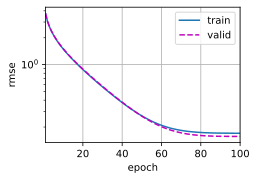

In [23]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')